# Fraud detection with deep neural networks


 * Simple text representations
 * Word embedding and transfer learning
 * Aggregating several data sources "the hard way"
 * Solving a very real ML problem with end-to-end deep learning

In [35]:
import random
import pymystem3
import itertools
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from gensim.models import KeyedVectors
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
 
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (a lot)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [44]:
df_original = pd.read_csv("avito_train.tsv",sep='\t')
df_original = df_original.fillna(value='NAN')

![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [45]:
print("Blocked ratio", df_original.is_blocked.mean())
print("Count:",len(df_original))

Blocked ratio 0.06882121065528005
Count: 3995803


### Exercise 2.1: Balance-out the classes
* Vast majority of data samples are non-prohibited
* only 23% banned in the downsampled dataset
* Let's balance out the classes by downsampling legal samples so that the number of positive and negative samples becomes equal
* This will make further steps less computationally demanding
* If you aim for high Kaggle score, consider a smarter approach to that.

In [220]:
# df = df[:10000]
df = df_original.sample(n=10000)

In [221]:
# your code goes here

not_blocked_ids = (df.is_blocked == 0).nonzero()[0]
blocked_ids = (df.is_blocked == 1).nonzero()[0]

not_blocked_ids = not_blocked_ids[:len(blocked_ids)]

df_b = df.iloc[blocked_ids]
df_nb = df.iloc[not_blocked_ids]

df = pd.concat([df.iloc[not_blocked_ids], df.iloc[blocked_ids]])

In [222]:
print("Blocked ratio:",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio: 0.5
Count: 1348


In [223]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print("done")

done


### Exercise 2.2: Initial preprocessing

* First, we lemmatize descriptions and titles (this brings all words to their normal form also known as lemma)
* Then, we tokenize them
* Finally, we put all words into a large list for further analysis

You know what to do.

In [225]:
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = pymystem3.Mystem()

def lemmatize_with_mystem(text):
    """Takes a string of text
    Return a string of lemmatized text"""
    
    an = lemmatizer.lemmatize(text)
    return ''.join(an).strip().lower()

In [226]:
# lemmatize titles and descriptions using the provided function
titles_lemmatized = [lemmatize_with_mystem(item) for item in tqdm(df.title.values)]
descriptions_lemmatized = [lemmatize_with_mystem(item) for item in tqdm(df.description.values)]







  0%|                                                                                         | 0/1348 [00:00<?, ?it/s]





  0%|                                                                                 | 1/1348 [00:02<46:39,  2.08s/it]





  0%|                                                                                 | 2/1348 [00:04<45:02,  2.01s/it]





  0%|▏                                                                                | 3/1348 [00:05<43:46,  1.95s/it]





  0%|▏                                                                                | 4/1348 [00:07<43:10,  1.93s/it]





  0%|▎                                                                                | 5/1348 [00:09<44:22,  1.98s/it]





  0%|▎                                                                                | 6/1348 [00:11<44:20,  1.98s/it]





  1%|▍                                                                                | 7/1348 [00:13<43:54,  1.96s/it]

  5%|███▊                                                                            | 65/1348 [02:02<40:19,  1.89s/it]





  5%|███▉                                                                            | 66/1348 [02:04<40:16,  1.88s/it]





  5%|███▉                                                                            | 67/1348 [02:06<40:13,  1.88s/it]





  5%|████                                                                            | 68/1348 [02:08<40:10,  1.88s/it]





  5%|████                                                                            | 69/1348 [02:09<40:07,  1.88s/it]





  5%|████▏                                                                           | 70/1348 [02:11<40:04,  1.88s/it]





  5%|████▏                                                                           | 71/1348 [02:13<40:01,  1.88s/it]





  5%|████▎                                                                           | 72/1348 [02:15<39:58,  1.88s/it]







 10%|███████▌                                                                       | 130/1348 [04:02<37:49,  1.86s/it]





 10%|███████▋                                                                       | 131/1348 [04:04<37:47,  1.86s/it]





 10%|███████▋                                                                       | 132/1348 [04:05<37:45,  1.86s/it]





 10%|███████▊                                                                       | 133/1348 [04:07<37:43,  1.86s/it]





 10%|███████▊                                                                       | 134/1348 [04:09<37:41,  1.86s/it]





 10%|███████▉                                                                       | 135/1348 [04:11<37:39,  1.86s/it]





 10%|███████▉                                                                       | 136/1348 [04:13<37:36,  1.86s/it]





 10%|████████                                                                       | 137/1348 [04:15<37:34,  1.86s/it]







 14%|███████████▍                                                                   | 195/1348 [06:04<35:56,  1.87s/it]





 15%|███████████▍                                                                   | 196/1348 [06:06<35:54,  1.87s/it]





 15%|███████████▌                                                                   | 197/1348 [06:08<35:53,  1.87s/it]





 15%|███████████▌                                                                   | 198/1348 [06:10<35:52,  1.87s/it]





 15%|███████████▋                                                                   | 199/1348 [06:13<35:53,  1.87s/it]





 15%|███████████▋                                                                   | 200/1348 [06:15<35:53,  1.88s/it]





 15%|███████████▊                                                                   | 201/1348 [06:17<35:51,  1.88s/it]





 15%|███████████▊                                                                   | 202/1348 [06:18<35:49,  1.88s/it]







 19%|███████████████▏                                                               | 260/1348 [08:09<34:09,  1.88s/it]





 19%|███████████████▎                                                               | 261/1348 [08:11<34:08,  1.88s/it]





 19%|███████████████▎                                                               | 262/1348 [08:13<34:06,  1.88s/it]





 20%|███████████████▍                                                               | 263/1348 [08:15<34:04,  1.88s/it]





 20%|███████████████▍                                                               | 264/1348 [08:17<34:02,  1.88s/it]





 20%|███████████████▌                                                               | 265/1348 [08:19<34:00,  1.88s/it]





 20%|███████████████▌                                                               | 266/1348 [08:21<33:59,  1.88s/it]





 20%|███████████████▋                                                               | 267/1348 [08:23<33:57,  1.88s/it]







 24%|███████████████████                                                            | 325/1348 [10:13<32:11,  1.89s/it]





 24%|███████████████████                                                            | 326/1348 [10:15<32:10,  1.89s/it]





 24%|███████████████████▏                                                           | 327/1348 [10:17<32:08,  1.89s/it]





 24%|███████████████████▏                                                           | 328/1348 [10:19<32:06,  1.89s/it]





 24%|███████████████████▎                                                           | 329/1348 [10:21<32:05,  1.89s/it]





 24%|███████████████████▎                                                           | 330/1348 [10:23<32:03,  1.89s/it]





 25%|███████████████████▍                                                           | 331/1348 [10:25<32:01,  1.89s/it]





 25%|███████████████████▍                                                           | 332/1348 [10:27<31:59,  1.89s/it]







 29%|██████████████████████▊                                                        | 390/1348 [12:17<30:10,  1.89s/it]





 29%|██████████████████████▉                                                        | 391/1348 [12:18<30:08,  1.89s/it]





 29%|██████████████████████▉                                                        | 392/1348 [12:20<30:06,  1.89s/it]





 29%|███████████████████████                                                        | 393/1348 [12:22<30:04,  1.89s/it]





 29%|███████████████████████                                                        | 394/1348 [12:24<30:03,  1.89s/it]





 29%|███████████████████████▏                                                       | 395/1348 [12:26<30:01,  1.89s/it]





 29%|███████████████████████▏                                                       | 396/1348 [12:28<29:59,  1.89s/it]





 29%|███████████████████████▎                                                       | 397/1348 [12:30<29:57,  1.89s/it]







 34%|██████████████████████████▋                                                    | 455/1348 [14:26<28:21,  1.90s/it]





 34%|██████████████████████████▋                                                    | 456/1348 [14:28<28:19,  1.91s/it]





 34%|██████████████████████████▊                                                    | 457/1348 [14:30<28:17,  1.91s/it]





 34%|██████████████████████████▊                                                    | 458/1348 [14:32<28:15,  1.91s/it]





 34%|██████████████████████████▉                                                    | 459/1348 [14:35<28:14,  1.91s/it]





 34%|██████████████████████████▉                                                    | 460/1348 [14:37<28:13,  1.91s/it]





 34%|███████████████████████████                                                    | 461/1348 [14:39<28:12,  1.91s/it]





 34%|███████████████████████████                                                    | 462/1348 [14:41<28:10,  1.91s/it]







 39%|██████████████████████████████▍                                                | 520/1348 [16:31<26:19,  1.91s/it]





 39%|██████████████████████████████▌                                                | 521/1348 [16:33<26:17,  1.91s/it]





 39%|██████████████████████████████▌                                                | 522/1348 [16:35<26:15,  1.91s/it]





 39%|██████████████████████████████▋                                                | 523/1348 [16:37<26:13,  1.91s/it]





 39%|██████████████████████████████▋                                                | 524/1348 [16:39<26:11,  1.91s/it]





 39%|██████████████████████████████▊                                                | 525/1348 [16:41<26:09,  1.91s/it]





 39%|██████████████████████████████▊                                                | 526/1348 [16:43<26:07,  1.91s/it]





 39%|██████████████████████████████▉                                                | 527/1348 [16:45<26:05,  1.91s/it]







 43%|██████████████████████████████████▎                                            | 585/1348 [18:36<24:15,  1.91s/it]





 43%|██████████████████████████████████▎                                            | 586/1348 [18:38<24:14,  1.91s/it]





 44%|██████████████████████████████████▍                                            | 587/1348 [18:40<24:12,  1.91s/it]





 44%|██████████████████████████████████▍                                            | 588/1348 [18:42<24:10,  1.91s/it]





 44%|██████████████████████████████████▌                                            | 589/1348 [18:43<24:08,  1.91s/it]





 44%|██████████████████████████████████▌                                            | 590/1348 [18:45<24:06,  1.91s/it]





 44%|██████████████████████████████████▋                                            | 591/1348 [18:47<24:04,  1.91s/it]





 44%|██████████████████████████████████▋                                            | 592/1348 [18:49<24:02,  1.91s/it]







 48%|██████████████████████████████████████                                         | 650/1348 [20:39<22:11,  1.91s/it]





 48%|██████████████████████████████████████▏                                        | 651/1348 [20:41<22:09,  1.91s/it]





 48%|██████████████████████████████████████▏                                        | 652/1348 [20:43<22:07,  1.91s/it]





 48%|██████████████████████████████████████▎                                        | 653/1348 [20:45<22:05,  1.91s/it]





 49%|██████████████████████████████████████▎                                        | 654/1348 [20:47<22:03,  1.91s/it]





 49%|██████████████████████████████████████▍                                        | 655/1348 [20:49<22:01,  1.91s/it]





 49%|██████████████████████████████████████▍                                        | 656/1348 [20:51<21:59,  1.91s/it]





 49%|██████████████████████████████████████▌                                        | 657/1348 [20:53<21:58,  1.91s/it]







 53%|█████████████████████████████████████████▉                                     | 715/1348 [22:45<20:09,  1.91s/it]





 53%|█████████████████████████████████████████▉                                     | 716/1348 [22:47<20:07,  1.91s/it]





 53%|██████████████████████████████████████████                                     | 717/1348 [22:49<20:05,  1.91s/it]





 53%|██████████████████████████████████████████                                     | 718/1348 [22:51<20:03,  1.91s/it]





 53%|██████████████████████████████████████████▏                                    | 719/1348 [22:53<20:01,  1.91s/it]





 53%|██████████████████████████████████████████▏                                    | 720/1348 [22:56<20:00,  1.91s/it]





 53%|██████████████████████████████████████████▎                                    | 721/1348 [22:58<19:59,  1.91s/it]





 54%|██████████████████████████████████████████▎                                    | 722/1348 [23:00<19:57,  1.91s/it]







 58%|█████████████████████████████████████████████▋                                 | 780/1348 [24:57<18:10,  1.92s/it]





 58%|█████████████████████████████████████████████▊                                 | 781/1348 [24:59<18:08,  1.92s/it]





 58%|█████████████████████████████████████████████▊                                 | 782/1348 [25:02<18:07,  1.92s/it]





 58%|█████████████████████████████████████████████▉                                 | 783/1348 [25:04<18:05,  1.92s/it]





 58%|█████████████████████████████████████████████▉                                 | 784/1348 [25:06<18:04,  1.92s/it]





 58%|██████████████████████████████████████████████                                 | 785/1348 [25:09<18:02,  1.92s/it]





 58%|██████████████████████████████████████████████                                 | 786/1348 [25:11<18:00,  1.92s/it]





 58%|██████████████████████████████████████████████                                 | 787/1348 [25:13<17:59,  1.92s/it]







 63%|█████████████████████████████████████████████████▌                             | 845/1348 [27:18<16:15,  1.94s/it]





 63%|█████████████████████████████████████████████████▌                             | 846/1348 [27:20<16:13,  1.94s/it]





 63%|█████████████████████████████████████████████████▋                             | 847/1348 [27:22<16:11,  1.94s/it]





 63%|█████████████████████████████████████████████████▋                             | 848/1348 [27:24<16:09,  1.94s/it]





 63%|█████████████████████████████████████████████████▊                             | 849/1348 [27:26<16:07,  1.94s/it]





 63%|█████████████████████████████████████████████████▊                             | 850/1348 [27:28<16:05,  1.94s/it]





 63%|█████████████████████████████████████████████████▊                             | 851/1348 [27:31<16:04,  1.94s/it]





 63%|█████████████████████████████████████████████████▉                             | 852/1348 [27:33<16:02,  1.94s/it]







 68%|█████████████████████████████████████████████████████▎                         | 910/1348 [29:40<14:17,  1.96s/it]





 68%|█████████████████████████████████████████████████████▍                         | 911/1348 [29:42<14:15,  1.96s/it]





 68%|█████████████████████████████████████████████████████▍                         | 912/1348 [29:44<14:13,  1.96s/it]





 68%|█████████████████████████████████████████████████████▌                         | 913/1348 [29:46<14:11,  1.96s/it]





 68%|█████████████████████████████████████████████████████▌                         | 914/1348 [29:48<14:09,  1.96s/it]





 68%|█████████████████████████████████████████████████████▌                         | 915/1348 [29:50<14:07,  1.96s/it]





 68%|█████████████████████████████████████████████████████▋                         | 916/1348 [29:52<14:05,  1.96s/it]





 68%|█████████████████████████████████████████████████████▋                         | 917/1348 [29:55<14:03,  1.96s/it]







 72%|█████████████████████████████████████████████████████████▏                     | 975/1348 [32:07<12:17,  1.98s/it]





 72%|█████████████████████████████████████████████████████████▏                     | 976/1348 [32:09<12:15,  1.98s/it]





 72%|█████████████████████████████████████████████████████████▎                     | 977/1348 [32:11<12:13,  1.98s/it]





 73%|█████████████████████████████████████████████████████████▎                     | 978/1348 [32:13<12:11,  1.98s/it]





 73%|█████████████████████████████████████████████████████████▎                     | 979/1348 [32:15<12:09,  1.98s/it]





 73%|█████████████████████████████████████████████████████████▍                     | 980/1348 [32:17<12:07,  1.98s/it]





 73%|█████████████████████████████████████████████████████████▍                     | 981/1348 [32:19<12:05,  1.98s/it]





 73%|█████████████████████████████████████████████████████████▌                     | 982/1348 [32:21<12:03,  1.98s/it]







 77%|████████████████████████████████████████████████████████████▏                 | 1040/1348 [34:32<10:13,  1.99s/it]





 77%|████████████████████████████████████████████████████████████▏                 | 1041/1348 [34:35<10:12,  1.99s/it]





 77%|████████████████████████████████████████████████████████████▎                 | 1042/1348 [34:38<10:10,  1.99s/it]





 77%|████████████████████████████████████████████████████████████▎                 | 1043/1348 [34:40<10:08,  1.99s/it]





 77%|████████████████████████████████████████████████████████████▍                 | 1044/1348 [34:42<10:06,  1.99s/it]





 78%|████████████████████████████████████████████████████████████▍                 | 1045/1348 [34:44<10:04,  1.99s/it]





 78%|████████████████████████████████████████████████████████████▌                 | 1046/1348 [34:46<10:02,  2.00s/it]





 78%|████████████████████████████████████████████████████████████▌                 | 1047/1348 [34:49<10:00,  2.00s/it]







 82%|███████████████████████████████████████████████████████████████▉              | 1105/1348 [37:02<08:08,  2.01s/it]





 82%|███████████████████████████████████████████████████████████████▉              | 1106/1348 [37:05<08:06,  2.01s/it]





 82%|████████████████████████████████████████████████████████████████              | 1107/1348 [37:07<08:04,  2.01s/it]





 82%|████████████████████████████████████████████████████████████████              | 1108/1348 [37:09<08:02,  2.01s/it]





 82%|████████████████████████████████████████████████████████████████▏             | 1109/1348 [37:11<08:00,  2.01s/it]





 82%|████████████████████████████████████████████████████████████████▏             | 1110/1348 [37:14<07:59,  2.01s/it]





 82%|████████████████████████████████████████████████████████████████▎             | 1111/1348 [37:17<07:57,  2.01s/it]





 82%|████████████████████████████████████████████████████████████████▎             | 1112/1348 [37:19<07:55,  2.01s/it]







 87%|███████████████████████████████████████████████████████████████████▋          | 1170/1348 [39:27<06:00,  2.02s/it]





 87%|███████████████████████████████████████████████████████████████████▊          | 1171/1348 [39:29<05:58,  2.02s/it]





 87%|███████████████████████████████████████████████████████████████████▊          | 1172/1348 [39:31<05:56,  2.02s/it]





 87%|███████████████████████████████████████████████████████████████████▊          | 1173/1348 [39:33<05:54,  2.02s/it]





 87%|███████████████████████████████████████████████████████████████████▉          | 1174/1348 [39:35<05:52,  2.02s/it]





 87%|███████████████████████████████████████████████████████████████████▉          | 1175/1348 [39:37<05:50,  2.02s/it]





 87%|████████████████████████████████████████████████████████████████████          | 1176/1348 [39:40<05:48,  2.02s/it]





 87%|████████████████████████████████████████████████████████████████████          | 1177/1348 [39:42<05:46,  2.02s/it]







 92%|███████████████████████████████████████████████████████████████████████▍      | 1235/1348 [41:46<03:49,  2.03s/it]





 92%|███████████████████████████████████████████████████████████████████████▌      | 1236/1348 [41:48<03:47,  2.03s/it]





 92%|███████████████████████████████████████████████████████████████████████▌      | 1237/1348 [41:50<03:45,  2.03s/it]





 92%|███████████████████████████████████████████████████████████████████████▋      | 1238/1348 [41:52<03:43,  2.03s/it]





 92%|███████████████████████████████████████████████████████████████████████▋      | 1239/1348 [41:54<03:41,  2.03s/it]





 92%|███████████████████████████████████████████████████████████████████████▊      | 1240/1348 [41:56<03:39,  2.03s/it]





 92%|███████████████████████████████████████████████████████████████████████▊      | 1241/1348 [41:58<03:37,  2.03s/it]





 92%|███████████████████████████████████████████████████████████████████████▊      | 1242/1348 [42:00<03:35,  2.03s/it]







 96%|███████████████████████████████████████████████████████████████████████████▏  | 1300/1348 [43:59<01:37,  2.03s/it]





 97%|███████████████████████████████████████████████████████████████████████████▎  | 1301/1348 [44:01<01:35,  2.03s/it]





 97%|███████████████████████████████████████████████████████████████████████████▎  | 1302/1348 [44:03<01:33,  2.03s/it]





 97%|███████████████████████████████████████████████████████████████████████████▍  | 1303/1348 [44:05<01:31,  2.03s/it]





 97%|███████████████████████████████████████████████████████████████████████████▍  | 1304/1348 [44:07<01:29,  2.03s/it]





 97%|███████████████████████████████████████████████████████████████████████████▌  | 1305/1348 [44:09<01:27,  2.03s/it]





 97%|███████████████████████████████████████████████████████████████████████████▌  | 1306/1348 [44:11<01:25,  2.03s/it]





 97%|███████████████████████████████████████████████████████████████████████████▋  | 1307/1348 [44:12<01:23,  2.03s/it]







  1%|▉                                                                               | 16/1348 [00:35<49:29,  2.23s/it]





  1%|█                                                                               | 17/1348 [00:38<49:38,  2.24s/it]





  1%|█                                                                               | 18/1348 [00:40<49:40,  2.24s/it]





  1%|█▏                                                                              | 19/1348 [00:42<49:50,  2.25s/it]





  1%|█▏                                                                              | 20/1348 [00:45<49:51,  2.25s/it]





  2%|█▏                                                                              | 21/1348 [00:47<49:54,  2.26s/it]





  2%|█▎                                                                              | 22/1348 [00:49<49:55,  2.26s/it]





  2%|█▎                                                                              | 23/1348 [00:52<49:55,  2.26s/it]







  6%|████▊                                                                           | 81/1348 [03:08<49:13,  2.33s/it]





  6%|████▊                                                                           | 82/1348 [03:11<49:10,  2.33s/it]





  6%|████▉                                                                           | 83/1348 [03:13<49:07,  2.33s/it]





  6%|████▉                                                                           | 84/1348 [03:15<49:06,  2.33s/it]





  6%|█████                                                                           | 85/1348 [03:18<49:03,  2.33s/it]





  6%|█████                                                                           | 86/1348 [03:20<49:00,  2.33s/it]





  6%|█████▏                                                                          | 87/1348 [03:22<48:58,  2.33s/it]





  7%|█████▏                                                                          | 88/1348 [03:24<48:55,  2.33s/it]







 11%|████████▌                                                                      | 146/1348 [05:49<48:00,  2.40s/it]





 11%|████████▌                                                                      | 147/1348 [05:52<47:58,  2.40s/it]





 11%|████████▋                                                                      | 148/1348 [05:54<47:55,  2.40s/it]





 11%|████████▋                                                                      | 149/1348 [05:57<47:53,  2.40s/it]





 11%|████████▊                                                                      | 150/1348 [05:59<47:52,  2.40s/it]





 11%|████████▊                                                                      | 151/1348 [06:02<47:50,  2.40s/it]





 11%|████████▉                                                                      | 152/1348 [06:04<47:47,  2.40s/it]





 11%|████████▉                                                                      | 153/1348 [06:06<47:45,  2.40s/it]







 16%|████████████▎                                                                  | 211/1348 [08:28<45:41,  2.41s/it]





 16%|████████████▍                                                                  | 212/1348 [08:31<45:40,  2.41s/it]





 16%|████████████▍                                                                  | 213/1348 [08:33<45:38,  2.41s/it]





 16%|████████████▌                                                                  | 214/1348 [08:36<45:35,  2.41s/it]





 16%|████████████▌                                                                  | 215/1348 [08:38<45:33,  2.41s/it]





 16%|████████████▋                                                                  | 216/1348 [08:40<45:30,  2.41s/it]





 16%|████████████▋                                                                  | 217/1348 [08:43<45:28,  2.41s/it]





 16%|████████████▊                                                                  | 218/1348 [08:45<45:25,  2.41s/it]







 20%|████████████████▏                                                              | 276/1348 [11:02<42:53,  2.40s/it]





 21%|████████████████▏                                                              | 277/1348 [11:05<42:51,  2.40s/it]





 21%|████████████████▎                                                              | 278/1348 [11:07<42:48,  2.40s/it]





 21%|████████████████▎                                                              | 279/1348 [11:09<42:46,  2.40s/it]





 21%|████████████████▍                                                              | 280/1348 [11:12<42:43,  2.40s/it]





 21%|████████████████▍                                                              | 281/1348 [11:14<42:41,  2.40s/it]





 21%|████████████████▌                                                              | 282/1348 [11:17<42:39,  2.40s/it]





 21%|████████████████▌                                                              | 283/1348 [11:19<42:37,  2.40s/it]







 25%|███████████████████▉                                                           | 341/1348 [13:42<40:27,  2.41s/it]





 25%|████████████████████                                                           | 342/1348 [13:44<40:25,  2.41s/it]





 25%|████████████████████                                                           | 343/1348 [13:46<40:22,  2.41s/it]





 26%|████████████████████▏                                                          | 344/1348 [13:49<40:20,  2.41s/it]





 26%|████████████████████▏                                                          | 345/1348 [13:52<40:19,  2.41s/it]





 26%|████████████████████▎                                                          | 346/1348 [13:55<40:18,  2.41s/it]





 26%|████████████████████▎                                                          | 347/1348 [13:57<40:16,  2.41s/it]





 26%|████████████████████▍                                                          | 348/1348 [14:00<40:14,  2.41s/it]







 30%|███████████████████████▊                                                       | 406/1348 [16:21<37:57,  2.42s/it]





 30%|███████████████████████▊                                                       | 407/1348 [16:23<37:54,  2.42s/it]





 30%|███████████████████████▉                                                       | 408/1348 [16:26<37:51,  2.42s/it]





 30%|███████████████████████▉                                                       | 409/1348 [16:28<37:49,  2.42s/it]





 30%|████████████████████████                                                       | 410/1348 [16:30<37:46,  2.42s/it]





 30%|████████████████████████                                                       | 411/1348 [16:33<37:43,  2.42s/it]





 31%|████████████████████████▏                                                      | 412/1348 [16:35<37:41,  2.42s/it]





 31%|████████████████████████▏                                                      | 413/1348 [16:37<37:38,  2.42s/it]







 35%|███████████████████████████▌                                                   | 471/1348 [19:01<35:25,  2.42s/it]





 35%|███████████████████████████▋                                                   | 472/1348 [19:04<35:23,  2.42s/it]





 35%|███████████████████████████▋                                                   | 473/1348 [19:06<35:20,  2.42s/it]





 35%|███████████████████████████▊                                                   | 474/1348 [19:08<35:18,  2.42s/it]





 35%|███████████████████████████▊                                                   | 475/1348 [19:11<35:15,  2.42s/it]





 35%|███████████████████████████▉                                                   | 476/1348 [19:13<35:13,  2.42s/it]





 35%|███████████████████████████▉                                                   | 477/1348 [19:15<35:10,  2.42s/it]





 35%|████████████████████████████                                                   | 478/1348 [19:18<35:07,  2.42s/it]







 40%|███████████████████████████████▍                                               | 536/1348 [21:33<32:40,  2.41s/it]





 40%|███████████████████████████████▍                                               | 537/1348 [21:36<32:38,  2.41s/it]





 40%|███████████████████████████████▌                                               | 538/1348 [21:39<32:35,  2.41s/it]





 40%|███████████████████████████████▌                                               | 539/1348 [21:42<32:34,  2.42s/it]





 40%|███████████████████████████████▋                                               | 540/1348 [21:44<32:32,  2.42s/it]





 40%|███████████████████████████████▋                                               | 541/1348 [21:47<32:30,  2.42s/it]





 40%|███████████████████████████████▊                                               | 542/1348 [21:50<32:28,  2.42s/it]





 40%|███████████████████████████████▊                                               | 543/1348 [21:52<32:25,  2.42s/it]







 45%|███████████████████████████████████▏                                           | 601/1348 [24:17<30:12,  2.43s/it]





 45%|███████████████████████████████████▎                                           | 602/1348 [24:20<30:09,  2.43s/it]





 45%|███████████████████████████████████▎                                           | 603/1348 [24:22<30:07,  2.43s/it]





 45%|███████████████████████████████████▍                                           | 604/1348 [24:25<30:04,  2.43s/it]





 45%|███████████████████████████████████▍                                           | 605/1348 [24:28<30:03,  2.43s/it]





 45%|███████████████████████████████████▌                                           | 606/1348 [24:31<30:01,  2.43s/it]





 45%|███████████████████████████████████▌                                           | 607/1348 [24:33<29:59,  2.43s/it]





 45%|███████████████████████████████████▋                                           | 608/1348 [24:36<29:56,  2.43s/it]







 49%|███████████████████████████████████████                                        | 666/1348 [26:56<27:35,  2.43s/it]





 49%|███████████████████████████████████████                                        | 667/1348 [26:58<27:32,  2.43s/it]





 50%|███████████████████████████████████████▏                                       | 668/1348 [27:00<27:30,  2.43s/it]





 50%|███████████████████████████████████████▏                                       | 669/1348 [27:03<27:27,  2.43s/it]





 50%|███████████████████████████████████████▎                                       | 670/1348 [27:05<27:25,  2.43s/it]





 50%|███████████████████████████████████████▎                                       | 671/1348 [27:08<27:23,  2.43s/it]





 50%|███████████████████████████████████████▍                                       | 672/1348 [27:11<27:20,  2.43s/it]





 50%|███████████████████████████████████████▍                                       | 673/1348 [27:13<27:18,  2.43s/it]







 54%|██████████████████████████████████████████▊                                    | 731/1348 [29:31<24:55,  2.42s/it]





 54%|██████████████████████████████████████████▉                                    | 732/1348 [29:34<24:52,  2.42s/it]





 54%|██████████████████████████████████████████▉                                    | 733/1348 [29:36<24:50,  2.42s/it]





 54%|███████████████████████████████████████████                                    | 734/1348 [29:38<24:48,  2.42s/it]





 55%|███████████████████████████████████████████                                    | 735/1348 [29:41<24:45,  2.42s/it]





 55%|███████████████████████████████████████████▏                                   | 736/1348 [29:43<24:43,  2.42s/it]





 55%|███████████████████████████████████████████▏                                   | 737/1348 [29:46<24:40,  2.42s/it]





 55%|███████████████████████████████████████████▎                                   | 738/1348 [29:48<24:38,  2.42s/it]







 59%|██████████████████████████████████████████████▋                                | 796/1348 [32:09<22:18,  2.42s/it]





 59%|██████████████████████████████████████████████▋                                | 797/1348 [32:12<22:15,  2.42s/it]





 59%|██████████████████████████████████████████████▊                                | 798/1348 [32:14<22:13,  2.42s/it]





 59%|██████████████████████████████████████████████▊                                | 799/1348 [32:17<22:11,  2.42s/it]





 59%|██████████████████████████████████████████████▉                                | 800/1348 [32:19<22:08,  2.42s/it]





 59%|██████████████████████████████████████████████▉                                | 801/1348 [32:23<22:07,  2.43s/it]





 59%|███████████████████████████████████████████████                                | 802/1348 [32:26<22:04,  2.43s/it]





 60%|███████████████████████████████████████████████                                | 803/1348 [32:28<22:02,  2.43s/it]







 64%|██████████████████████████████████████████████████▍                            | 861/1348 [34:59<19:47,  2.44s/it]





 64%|██████████████████████████████████████████████████▌                            | 862/1348 [35:02<19:45,  2.44s/it]





 64%|██████████████████████████████████████████████████▌                            | 863/1348 [35:04<19:42,  2.44s/it]





 64%|██████████████████████████████████████████████████▋                            | 864/1348 [35:06<19:40,  2.44s/it]





 64%|██████████████████████████████████████████████████▋                            | 865/1348 [35:09<19:37,  2.44s/it]





 64%|██████████████████████████████████████████████████▊                            | 866/1348 [35:11<19:35,  2.44s/it]





 64%|██████████████████████████████████████████████████▊                            | 867/1348 [35:13<19:32,  2.44s/it]





 64%|██████████████████████████████████████████████████▊                            | 868/1348 [35:16<19:30,  2.44s/it]







 69%|██████████████████████████████████████████████████████▎                        | 926/1348 [37:44<17:11,  2.45s/it]





 69%|██████████████████████████████████████████████████████▎                        | 927/1348 [37:46<17:09,  2.45s/it]





 69%|██████████████████████████████████████████████████████▍                        | 928/1348 [37:49<17:07,  2.45s/it]





 69%|██████████████████████████████████████████████████████▍                        | 929/1348 [37:52<17:04,  2.45s/it]





 69%|██████████████████████████████████████████████████████▌                        | 930/1348 [37:54<17:02,  2.45s/it]





 69%|██████████████████████████████████████████████████████▌                        | 931/1348 [37:57<17:00,  2.45s/it]





 69%|██████████████████████████████████████████████████████▌                        | 932/1348 [38:00<16:57,  2.45s/it]





 69%|██████████████████████████████████████████████████████▋                        | 933/1348 [38:02<16:55,  2.45s/it]







 74%|██████████████████████████████████████████████████████████                     | 991/1348 [40:37<14:38,  2.46s/it]





 74%|██████████████████████████████████████████████████████████▏                    | 992/1348 [40:40<14:35,  2.46s/it]





 74%|██████████████████████████████████████████████████████████▏                    | 993/1348 [40:42<14:33,  2.46s/it]





 74%|██████████████████████████████████████████████████████████▎                    | 994/1348 [40:45<14:30,  2.46s/it]





 74%|██████████████████████████████████████████████████████████▎                    | 995/1348 [40:47<14:28,  2.46s/it]





 74%|██████████████████████████████████████████████████████████▎                    | 996/1348 [40:50<14:26,  2.46s/it]





 74%|██████████████████████████████████████████████████████████▍                    | 997/1348 [40:53<14:23,  2.46s/it]





 74%|██████████████████████████████████████████████████████████▍                    | 998/1348 [40:55<14:21,  2.46s/it]







 78%|█████████████████████████████████████████████████████████████                 | 1056/1348 [43:28<12:01,  2.47s/it]





 78%|█████████████████████████████████████████████████████████████▏                | 1057/1348 [43:31<11:58,  2.47s/it]





 78%|█████████████████████████████████████████████████████████████▏                | 1058/1348 [43:34<11:56,  2.47s/it]





 79%|█████████████████████████████████████████████████████████████▎                | 1059/1348 [43:37<11:54,  2.47s/it]





 79%|█████████████████████████████████████████████████████████████▎                | 1060/1348 [43:42<11:52,  2.47s/it]





 79%|█████████████████████████████████████████████████████████████▍                | 1061/1348 [43:47<11:50,  2.48s/it]





 79%|█████████████████████████████████████████████████████████████▍                | 1062/1348 [43:50<11:48,  2.48s/it]





 79%|█████████████████████████████████████████████████████████████▌                | 1063/1348 [43:56<11:46,  2.48s/it]







 83%|████████████████████████████████████████████████████████████████▊             | 1121/1348 [47:08<09:32,  2.52s/it]





 83%|████████████████████████████████████████████████████████████████▉             | 1122/1348 [47:16<09:31,  2.53s/it]





 83%|████████████████████████████████████████████████████████████████▉             | 1123/1348 [47:21<09:29,  2.53s/it]





 83%|█████████████████████████████████████████████████████████████████             | 1124/1348 [47:24<09:26,  2.53s/it]





 83%|█████████████████████████████████████████████████████████████████             | 1125/1348 [47:28<09:24,  2.53s/it]





 84%|█████████████████████████████████████████████████████████████████▏            | 1126/1348 [47:31<09:22,  2.53s/it]





 84%|█████████████████████████████████████████████████████████████████▏            | 1127/1348 [47:34<09:19,  2.53s/it]





 84%|█████████████████████████████████████████████████████████████████▎            | 1128/1348 [47:38<09:17,  2.53s/it]







 88%|████████████████████████████████████████████████████████████████████▋         | 1186/1348 [50:44<06:55,  2.57s/it]





 88%|████████████████████████████████████████████████████████████████████▋         | 1187/1348 [50:47<06:53,  2.57s/it]





 88%|████████████████████████████████████████████████████████████████████▋         | 1188/1348 [50:52<06:51,  2.57s/it]





 88%|████████████████████████████████████████████████████████████████████▊         | 1189/1348 [50:55<06:48,  2.57s/it]





 88%|████████████████████████████████████████████████████████████████████▊         | 1190/1348 [50:58<06:46,  2.57s/it]





 88%|████████████████████████████████████████████████████████████████████▉         | 1191/1348 [51:01<06:43,  2.57s/it]





 88%|████████████████████████████████████████████████████████████████████▉         | 1192/1348 [51:04<06:41,  2.57s/it]





 89%|█████████████████████████████████████████████████████████████████████         | 1193/1348 [51:07<06:38,  2.57s/it]







 93%|████████████████████████████████████████████████████████████████████████▍     | 1251/1348 [53:59<04:11,  2.59s/it]





 93%|████████████████████████████████████████████████████████████████████████▍     | 1252/1348 [54:01<04:08,  2.59s/it]





 93%|████████████████████████████████████████████████████████████████████████▌     | 1253/1348 [54:03<04:05,  2.59s/it]





 93%|████████████████████████████████████████████████████████████████████████▌     | 1254/1348 [54:05<04:03,  2.59s/it]





 93%|████████████████████████████████████████████████████████████████████████▌     | 1255/1348 [54:07<04:00,  2.59s/it]





 93%|████████████████████████████████████████████████████████████████████████▋     | 1256/1348 [54:09<03:58,  2.59s/it]





 93%|████████████████████████████████████████████████████████████████████████▋     | 1257/1348 [54:11<03:55,  2.59s/it]





 93%|████████████████████████████████████████████████████████████████████████▊     | 1258/1348 [54:13<03:52,  2.59s/it]







 98%|████████████████████████████████████████████████████████████████████████████▏ | 1316/1348 [56:04<01:21,  2.56s/it]





 98%|████████████████████████████████████████████████████████████████████████████▏ | 1317/1348 [56:06<01:19,  2.56s/it]





 98%|████████████████████████████████████████████████████████████████████████████▎ | 1318/1348 [56:08<01:16,  2.56s/it]





 98%|████████████████████████████████████████████████████████████████████████████▎ | 1319/1348 [56:10<01:14,  2.56s/it]





 98%|████████████████████████████████████████████████████████████████████████████▍ | 1320/1348 [56:12<01:11,  2.55s/it]





 98%|████████████████████████████████████████████████████████████████████████████▍ | 1321/1348 [56:14<01:08,  2.55s/it]





 98%|████████████████████████████████████████████████████████████████████████████▍ | 1322/1348 [56:16<01:06,  2.55s/it]





 98%|████████████████████████████████████████████████████████████████████████████▌ | 1323/1348 [56:18<01:03,  2.55s/it]







In [227]:
# tokenize titles and descriptions using the provided tokenizer
titles_tokeized = [tokenizer.tokenize(item) for item in tqdm(titles_lemmatized)]
descriptions_tokeized = [tokenizer.tokenize(item) for item in tqdm(descriptions_lemmatized)]







  0%|                                                                                         | 0/1348 [00:00<?, ?it/s]





100%|███████████████████████████████████████████████████████████████████████████| 1348/1348 [00:00<00:00, 74851.68it/s]





  0%|                                                                                         | 0/1348 [00:00<?, ?it/s]





100%|███████████████████████████████████████████████████████████████████████████| 1348/1348 [00:00<00:00, 20113.27it/s]

In [228]:
# join all tokens into a list
all_tokens = []
for token in titles_tokeized+descriptions_tokeized:
    all_tokens += token
len(all_tokens)

59337

In [229]:
all_tokens[:10]

['продавать',
 'гармонь',
 'тульский',
 'продавать',
 'новый',
 'ботинок',
 'мужской',
 'из',
 'натуральный',
 'кожа']

In [230]:
assert len(titles_tokeized) == len(descriptions_tokeized)
assert isinstance(titles_tokeized, list) and isinstance(descriptions_tokeized, list)
assert all([isinstance(t, list) for t in titles_tokeized]) and all([isinstance(t, list) for t in descriptions_tokeized])
assert all([all([isinstance(tok, str) for tok in t]) for t in titles_tokeized]) and all([
    all([isinstance(tok, str) for tok in t]) for t in descriptions_tokeized])
assert isinstance(all_tokens, list) and all([isinstance(t, str) for t in all_tokens])
print('done')

done


### Exercise 2.3: Dictionaries and tranfer learning

To encode words as dense vectors for our DNN we will use a pre-trained word2vec model.
It has been trained on ~1 Billion russian documents obtained from the WWW.

Since the corpus is so large, the quality of word vecors is higher than it would be if we trained such a model by ourselves. Moreover, it saves us a lot of time

The act of using a model trained by someone else to solve the problem at hand is called [Transfer Learning](https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/).

### First, download and load up the pretrained word2vec model. It can be obtained from [here](https://drive.google.com/file/d/1shM7FznB9lHkdTxmqkbY2r3El_UzPzvl/view?usp=sharing)

In [232]:
wmod = KeyedVectors.load_word2vec_format("C:/Users/artur/aca-nlp/lecture4/word_vectors.w2v")

### Next, modify our good old build_vocabulary function, so that it only adds tokens present in the word embedding model to the vocabulary

In [234]:
def build_vocabulary(tokens, emb_mod, max_size=20000):
    """
    Builds a vocabulary of at most max_size words from the supplied list of lists of tokens.
    Only includes words that are present in emb_mod into the vocabulary.
    """
    vocabulary = {}
    reserved_symbols = ["NULL", "UNKN"]
    
    counter = collections.Counter(tokens)
    
    freq_toks = counter.most_common(max_size-len(reserved_symbols))

    voc_words = [k[0] for k in freq_toks]

    for i, reserved in enumerate(reserved_symbols):
        vocabulary[reserved] = i
    
    i = 0
    for k in voc_words:
        if k in emb_mod:
            vocabulary[k] = i+len(reserved_symbols)
            i += 1

    return vocabulary

In [238]:
token_to_id = build_vocabulary(all_tokens, wmod)

In [239]:
id_to_token = {v:k for k,v in token_to_id.items()}

In [240]:
print(len(token_to_id))

8242


In [241]:
# assert len(token_to_id) > 30000 and len(token_to_id) < 100000
assert {'NULL', 'UNKN'}.issubset(set(token_to_id.keys()))
print('done')

done


### Finally, build a function that builds a matrix of word embeddings

In [242]:
def get_embeddings(emb_mod, id_to_token, dim=300):
    """Using the provided word embedding model 'emb_mod' and the 'id_to_token' dictionary
    generates a matrix, such that the embedding for word with id I can be found on the
    I-th row of that matrix
    
    For words that are not present in the word embedding model, the function writes 
    a vector of zeroes of length 'dim' to corresponding rows
    
    Returns a matrix of shape [len(id_to_token), dim]
    """
    myembeddings = []
    not_found = np.zeros((dim,))
    for i in range(len(id_to_token)):
        if id_to_token[i] in emb_mod:
            myembeddings.append(emb_mod[id_to_token[i]])
        else:
            myembeddings.append(not_found)
    return np.array(myembeddings)

In [243]:
embs_matrix = get_embeddings(wmod, id_to_token)
embs_matrix.shape

(8242, 300)

In [244]:
assert isinstance(embs_matrix, np.ndarray)
assert embs_matrix.shape[0] == len(id_to_token)
assert embs_matrix.shape[1] == wmod.vector_size
for word in token_to_id:
    if word in wmod:
        assert np.linalg.norm(wmod[word] - embs_matrix[token_to_id[word]]) < 1e-6
print('done')

done


In [245]:
# we are done with the pretrained model, so we delete it to free up some RAM
del wmod

### Exercise 2.4: Text vectorization

### Replace words with IDs
Select a reasonable maximum length for encoding descriptions and titles based on a distribution of their lengths.
Then vectorize the texts 
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [246]:
desc_lists = [len(t) for t in descriptions_tokeized]
title_lists = [len(t) for t in titles_tokeized]

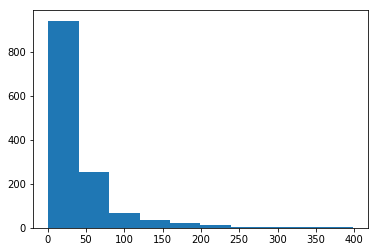

In [247]:
# np.mean(desc_lists) = 35.5138888

_ = plt.hist(desc_lists)

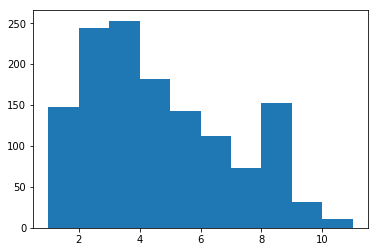

In [248]:
# np.mean(title_lists) = 4.208333

_ = plt.hist(title_lists)

In [249]:
from tqdm import tqdm
def vectorize_tokens(tokens, token_to_id, max_len):
    """
    Converts a list of tokens to a list of token ids using the supplied dictionary.
    Pads resulting list with NULL identifiers up to max_len length.
    """
    ids = []
    for token in tokens:
        ids.append(token_to_id.get(token, token_to_id["UNKN"]))
    
    if len(ids) < max_len:
        ids += (max_len-len(ids))*[token_to_id["NULL"]]
    else:
        ids = ids[:max_len]
    return ids

In [250]:
desc_tokens = np.array([vectorize_tokens(item, token_to_id, 40) 
               for item in descriptions_tokeized])
title_tokens = np.array([vectorize_tokens(item, token_to_id, 6) 
                for item in titles_tokeized])

In [251]:
assert isinstance(desc_tokens, np.ndarray) and isinstance(title_tokens, np.ndarray)
assert desc_tokens.shape[1] > 30 and desc_tokens.shape[1] < 256
assert title_tokens.shape[1] > 4 and title_tokens.shape[1] < 32
print('done')

done


### Data format examples


In [252]:
print("Matrix shape:",title_tokens.shape)
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Matrix shape: (1348, 6)
Продам гармонь Тульскую -> [   2 2737 2084    0    0    0] ...
Продам новые ботинки мужские из натуральной кожи -> [   2    8  608 1389    1  206] ...
Hyundai Getz, 2004 -> [1015 2738    1    0    0    0] ...


### Encoding non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing approach.

No need to change anything there, just follow the code

In [253]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [254]:
#All categorical features
categories = []
data_cat_subcat = df[["category","subcategory"]].values

In [255]:
categories = [{"category":d[0], "subcategory":d[1]} for d in data_cat_subcat]
vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [256]:
df_non_text = pd.merge(df_numerical_features, cat_one_hot, on = np.arange(len(cat_one_hot)))
del df_non_text["key_0"]

# Split data into training and test

In [257]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = np.array(df_non_text.astype('float32'))

In [258]:
from sklearn.model_selection import train_test_split

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(
    title_tokens, desc_tokens, df_non_text, target)

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [260]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print("Saving preprocessed data (may take some time)")
    data_tuple = title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts
    import pickle
    with open("preprocessed_data.pkl",'wb') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pkl",'wb') as fout:
        pickle.dump(token_to_id,fout)

    print("done")
    
elif read_prepared_data:
    print("Reading saved data...")
    
    import pickle
    
    with open("preprocessed_data.pkl",'rb') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pkl",'rb') as fin:
        token_to_id = pickle.load(fin)

    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
        
    print("done")

Reading saved data...
done


# Build the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles
 * RNN encoder 
* Separate input for description
 * RNN encoder
* Separate input for categorical features (optional)
 * Linear layers are good for these
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal unit with binary_crossentropy 

In [261]:
import keras

# NN architecture

![caption](./model.png)

### Inputs

In [262]:
title_input_layer = keras.layers.Input(shape=(title_tr.shape[1],))
description_input_layer = keras.layers.Input(shape=(desc_tr.shape[1],))

In [263]:
title_input_layer, description_input_layer

(<tf.Tensor 'input_3:0' shape=(?, 6) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(?, 40) dtype=float32>)

### Embedding containers

In [264]:
embedding_layer_title = keras.layers.Embedding(embs_matrix.shape[0], embs_matrix.shape[1], 
                                               input_length=title_tr.shape[1], weights=[embs_matrix],
                                               trainable=False)(title_input_layer)

embedding_layer_descr = keras.layers.Embedding(embs_matrix.shape[0], embs_matrix.shape[1], 
                                               input_length=desc_tr.shape[1], weights=[embs_matrix],
                                               trainable=False)(description_input_layer)

In [265]:
embedding_layer_title, embedding_layer_descr

(<tf.Tensor 'embedding_3/embedding_lookup:0' shape=(?, 6, 300) dtype=float32>,
 <tf.Tensor 'embedding_4/embedding_lookup:0' shape=(?, 40, 300) dtype=float32>)

### RNN encoders for text

In [266]:
encoder_title = keras.layers.LSTM(32)(embedding_layer_title)
encoder_descr = keras.layers.LSTM(128)(embedding_layer_descr)

In [267]:
encoder_title, encoder_descr

(<tf.Tensor 'lstm_3/TensorArrayReadV3:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'lstm_4/TensorArrayReadV3:0' shape=(?, 128) dtype=float32>)

### Concatenation layer

In [268]:
concat_layer = keras.layers.concatenate([encoder_title, encoder_descr])

In [269]:
concat_layer

<tf.Tensor 'concatenate_2/concat:0' shape=(?, 160) dtype=float32>

### Multilayer Perceptron with with sigmoidal activation function on the output node

In [270]:
dense_layer = keras.layers.Dense(64, activation='relu')(concat_layer)
final_layer = keras.layers.Dense(1, activation='sigmoid')(dense_layer)

In [271]:
dense_layer, final_layer

(<tf.Tensor 'dense_5/Relu:0' shape=(?, 64) dtype=float32>,
 <tf.Tensor 'dense_6/Sigmoid:0' shape=(?, 1) dtype=float32>)

In [272]:
model = keras.models.Model(inputs=[title_input_layer, 
                                   description_input_layer], outputs=[final_layer])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the monster!


In [274]:
model.fit(x=[title_tr, desc_tr], y=target_tr, batch_size=64, epochs=5, 
               validation_data=[[title_ts, desc_ts], target_ts])

Train on 1011 samples, validate on 337 samples
Epoch 1/5
1011/1011 [==============================] - ETA: 5s - loss: 0.5560 - acc: 0.703 - ETA: 5s - loss: 0.5530 - acc: 0.734 - ETA: 4s - loss: 0.5770 - acc: 0.718 - ETA: 4s - loss: 0.5462 - acc: 0.730 - ETA: 4s - loss: 0.5179 - acc: 0.746 - ETA: 3s - loss: 0.5034 - acc: 0.757 - ETA: 3s - loss: 0.4896 - acc: 0.765 - ETA: 2s - loss: 0.4843 - acc: 0.769 - ETA: 2s - loss: 0.4805 - acc: 0.772 - ETA: 2s - loss: 0.4659 - acc: 0.781 - ETA: 1s - loss: 0.4498 - acc: 0.791 - ETA: 1s - loss: 0.4524 - acc: 0.793 - ETA: 1s - loss: 0.4410 - acc: 0.799 - ETA: 0s - loss: 0.4368 - acc: 0.800 - ETA: 0s - loss: 0.4277 - acc: 0.806 - 6s 6ms/step - loss: 0.4325 - acc: 0.8042 - val_loss: 0.3541 - val_acc: 0.8576
Epoch 2/5
1011/1011 [==============================] - ETA: 5s - loss: 0.2336 - acc: 0.906 - ETA: 5s - loss: 0.2677 - acc: 0.890 - ETA: 4s - loss: 0.2730 - acc: 0.890 - ETA: 4s - loss: 0.2972 - acc: 0.871 - ETA: 4s - loss: 0.2769 - acc: 0.884 - ETA: 

### Tweaking guide
* categorical and numerical features - use them
  * a good starting point would be to build an MLP to process them
  * then concatenate it's output together with the RNN encoder outputs
* layers - stack more of them
  * the above model is quite basic
  * add more linear layers
  * increase the dimensionality of RNN encoders
  * consider trying out Conv + Global Max Pooling layers for text (see lecture 4 for an example)
* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [209]:
print("If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. ")

If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. 


# Final evaluation
Evaluate network over the entire test set

In [275]:
preds = model.predict([title_ts, desc_ts])

In [276]:
from sklearn.metrics import roc_auc_score, classification_report

In [277]:
print(classification_report(target_ts, preds>0.5))

             precision    recall  f1-score   support

          0       0.88      0.91      0.89       163
          1       0.92      0.88      0.90       174

avg / total       0.90      0.90      0.90       337



In [278]:
print(roc_auc_score(target_ts, preds))

0.9423171849657994


# Main task
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther


* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92


* Remember the training
 * Mommentum, RMSprop, adam
 * Dropout, regularization
 * Convolutions, pooling
 * Improving tokenizer, better preprocessing, using all available data instead of downsampling etc etc.
 